<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/imagenette_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git
!pip install efficientnet-pytorch

In [2]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import *
from fastai.utils.show_install import *

show_install()




```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61.dev0
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installe

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
bs = 32
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs, valid_pct = 0.2).normalize(imagenet_stats)



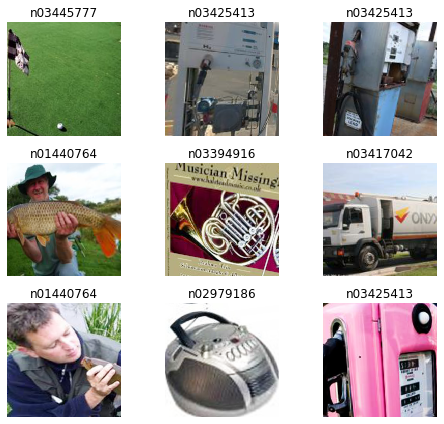

In [6]:
data.show_batch(rows=3, figsize=(7,6))

# Train Teacher


In [7]:
try: 
    learn.destroy()
except:
    print('no learner created')

no learner created


In [8]:
learn = cnn_learner(data, models.resnet34, pretrained = True, loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
               metrics = [accuracy])
learn.to_fp16();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
# learn.unfreeze();

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion = True)


In [0]:
lr = 1e-2



learn.fit_one_cycle(6,
                    lr,
                    callbacks = [SaveModelCallback(learn, every='improvement', monitor='accuracy', name='classifier_stage1')])


# Distillation

In [0]:
def distillation(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


In [0]:
@dataclass
class BasicLearner():
    model:nn.Module
    loss_func:LossFunction
    opt:optim.Optimizer
    data:DataBunch


def loss_batch_distill(model:nn.Module, teacher_model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None):
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    teacher_scores = teacher_model(*xb) # outputs from teacher model
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), to_detach(yb[0])
    loss = loss_func(out, *yb, teacher_scores, T=20., alpha = 0.7)

    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()

    return loss.detach().cpu()

def fit_distill(epochs:int, learn:BasicLearner, learn_teacher:BasicLearner, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss_func` and `opt`."
    assert len(learn.data.train_dl) != 0, f"""Your training dataloader is empty, can't train a model.
        Use a smaller batch size (batch size={learn.data.train_dl.batch_size} for {len(learn.data.train_dl.dataset)} elements)."""
    cb_handler = CallbackHandler(callbacks, metrics)
    pbar = master_bar(range(epochs))
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)

    exception=False
    try:
        for epoch in pbar:
            learn.model.train()
            learn_teacher.model.eval() # setting teacher to eval
            cb_handler.set_dl(learn.data.train_dl)
            cb_handler.on_epoch_begin()
            for xb,yb in progress_bar(learn.data.train_dl, parent=pbar):
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                loss = loss_batch_distill(learn.model, learn_teacher.model, xb, yb, learn.loss_func, learn.opt, cb_handler) # change loss_batch
                if cb_handler.on_batch_end(loss): break

            if not cb_handler.skip_validate and not learn.data.empty_val:
                val_loss = validate(learn.model, learn.data.valid_dl, loss_func=learn.loss_func,
                                       cb_handler=cb_handler, pbar=pbar)
            else: val_loss=None
            if cb_handler.on_epoch_end(val_loss): break
    except Exception as e:
        exception = e
        raise
    finally: cb_handler.on_train_end(exception)

In [0]:
learn_student = cnn_learner(data, models.resnet18, pretrained = True, loss_func = distillation,
               metrics = [accuracy])
learn_student.to_fp16();

In [35]:
fit_distill(3,
            learn_student,
            learn)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


TypeError: ignored